<a href="https://colab.research.google.com/github/ravindrabharathi/Project1/blob/master/Session4/First_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a Convolutional Neural Network with less than 15000 parameters to achieve a validation accuracy of 99.4 or more for MNIST dataset 


The target is to build a deep learning CNN model with as little parameters as possible and at the same time achieve a high validation accuracy of 99.4 or more . The low parameter count becomes important when deploying the model in memory constrained devices used in edge computing . MNIST is one of the more popular (and simpler) datasets to begin your journey in Vision based Deep learning. We will use this MNIST dataset for this exercise. 

We will build the model step by step . Broadly speaking we will follow these steps 

1. Decide on the basic architecture for the network 
2. Fine tune parameters to comply with the 15000 limit
3. Add improvements to the network using Batch Normalization 
4. See if we can converge faster while learning by using Dropouts to overcome overfitting ,higher   learning rates, etc 

In this notebook we will fix the Basic architecture that we think is suitable without bothering about number of parameters 

###Import necessary libraries / modules
Import numpy library for array/ matrix operations

Import Sequential Model from keras/models for building the model

Import Conv2D , Activation , Flatten , BatchNormalization, MaxPooling2D from keras/layers 

Import np_utils module from keras/utils for numpy related helper functions

Import mnist dataset containing hand-written digits images from keras.datasets

In [0]:
import numpy as np

from keras.models import Sequential,load_model
from keras.layers import Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import np_utils

from keras.datasets import mnist

Using TensorFlow backend.


### Load pre-shuffled MNIST data into train and test sets

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


###print the shape of training data and also inspect the first image using matplotlib

(60000, 28, 28)


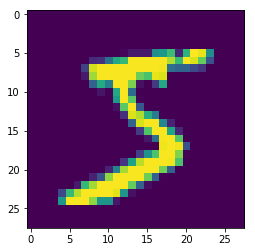

In [0]:
print (X_train.shape)
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(X_train[0])

####Reshape the training and test dataset to include the channel information.In this case it is a greyscale image and so there is 1 channel . the image data was read in as a 28x28 numpy array and is now reshaped to 28x28x1

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

###Cast training data as float32 and normalize/re-scale the values such that they are between 0 and 1 instead of 0 and 255

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

###inspect the first 10 training class labels . They will be some number between 0 and 9 representing the hand-written digit in the corresponding Training data. Each of 0 to 9 represents a class

In [0]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

####One hot encoding of training and test class labels : Convert 1-dimensional class arrays to 10-dimensional class matrices

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [0]:
Y_train[:10]


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

###Define a ModelCheckPoint callback which will be called at the end of every training epoch . We will use this callback function to save the model whenever vallidation accuracy improves . We do this so that we can load and use the best model for further predictions after training 

In [0]:
from keras.callbacks import ModelCheckpoint
  
#chkpoint_model=ModelCheckpoint("/gdrive/My Drive/EVA/Session3/model_customv1_mnist_best.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max') 

chkpoint_model=ModelCheckpoint("model_custom_v1_mnist_best.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max') 



#Building the model version 1

In version 1 of the model we will try and get the basic architecture correct. We will focus on adding the proper convolution layers that gives a good enough accuracy to start with . We will not bother about the parameter constraints at this point.

In our architecture for every convolution block we start from a small number and increase the number of filters for every additional layer in the block . Typically for a 400x400 image we would go upto a receptive field of 11x11 starting from 32 kernels increasing to 512 kernels such that the network learns enough about edges, gradients ,textures, patterns, parts of object , object and scene in each progressive block . In our case the images are small and relative much simpler and so we will use lesser number of blocks and also lesser layers within each block.

Considering the size of the image (28x28) and the relative simple nature of the classes (digits 0-9) to be classified, we will add only two convolution blocks containing 3x3 filters until we get to a channel size of  7x7 .  At the point where the channel size is 7X7 , we will add a convolution block of 10 filters of size 7x7 which feeds into a flatten layer followed by softmax activation . Between these two convolution blocks we will have a transition block of 1x1 convolution and maxpooling .

We will not add convolution layers after the channel size has reached 7x7 . This is because when a 3x3 filter convolves over an image of size 5x5 it sees the pixels a disproportionate number of times as seen below and convovling further doesn't retain enough spatial information   


<img src="https://raw.githubusercontent.com/ravindrabharathi/eip3/master/images/pixels-55.png" alt="drawing" width="300"/> &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; <img src="https://raw.githubusercontent.com/ravindrabharathi/eip3/master/images/pixels-77.png" alt="drawing" width="300"/>

All these convolution layers will use ReLU activation function . Using an activation function introduces non-linearity in the network allowing them to learn complex functions .Without these non-linear activation functions the network will only be a stack of linear functions . ReLU activation is one of the simplest and most popular activations used in CNN . It essentially suppresses -ve values from moving forward giving the network a simple rule for retaining or discarding features that it is learning - work towards making values positive if you want something retained and make the values negative if you want to drop something. 

First convolution layer :

The first convolution layer will have 32 3x3 kernels 

First Convolution Block :

The first block allows the network to learn edges and gradients. This block will have 2 layers of convolution filters of size 3x3 . The number of kernels in the first layer is 64 (increses from 32 used in the first convolution layer ) and the second layer has 128 kernels . With a global receptive field of 7x7 , the network should be able to learn enough about edges and gradients . 

Transition Block : 
since we want to start the next convolution block at a smaller number of kernels , we will use a 1x1 convolution layer to reduce the number of channels after the first convolution block . 1x1 kernel convolution is an effective  way of combining a large number of channels to form a set of smaller number of channels. 
We will also spatially downsample the channels by using maxpooling of size 2x2. Maxpooling of size 2x2 will reduce the channel size by half while doubling the global receptive field 

Second convolution block : 

The second block will allow the network to form the important parts that make up the digits . This will contain two layers of 3x3 kernels . Firts layer will have 64 kernels and the second will have 128 kernels . 

1x1 convolution to transition to 10 channels :

After the second convolution block we add a convolution layer of 10 1x1 kernels .  Since we have only 10 classes , we will combine the 16 channels from earlier layers to form 10 channels .

Last Layer : 7x7 kernel 

Since we stopped our second convolution block at an activation size of 7x7 , we will add a convolution layer of 10 numbers of 7x7 kernels as the last layer in order to send a 1x1x10 output to the Flatten layer .
It is important not to have ReLU activation for this 1x1 layer since we want all values from the convolution to go to the Softmax activation to make its prediction . If we use a ReLu activation , the -ve values will be suppressed and the network will be unable to train in an optimal manner.

Flatten: 

These 10 channel outputs are fed to a Flatten layer that converts the 2d array representation to a 1d shape . 

Softmax activation: 

A softmax activation layer at the end outputs the class probabilities of these 10 classes which in our case are the digits 0 to 9 . 



In [0]:
# to get a certain degeree of predictability when generating random numbers,
# set a random seed to initialize the pseudo-random number generator 
np.random.seed(seed=42)  

# instantiate a sequential model
model = Sequential()

# add the first convolution layer - 32 numbers of 3x3 filters , 
#This layer sees the input image of 28x28 x 1 channel . 

model.add(Conv2D(32, (3, 3), input_shape=(28,28,1), use_bias=False))  # remove bias param by setting it to false 
  
model.add(Activation('relu'))    # use ReLU activation function .

# Now the global receptive field is 3 x 3 

# First Convolution Block
# Block1 conv layer 1 - 64 filters of shape  3x3x32 
# input from previous layer is 26 x 26 x 32 . 

## Block 1

model.add(Conv2D(64, 3, use_bias=False))  # remove bias param by setting it to false 
 
model.add(Activation('relu'))    # use ReLU activation function .

#Global receptive field is 5x5

# Add convolution layer - 128 filters of shape  3x3x64 
#input from previous layer is 24 x 24 x 64 . 

model.add(Conv2D(128, 3, use_bias=False))  # remove bias param by setting it to false 
 
model.add(Activation('relu'))    # use ReLU activation function .


#Global receptive field is 7x7

##  Transition block 

# Perform 2x2 max pooling  . 
#Input from previous layer is 22 x 22 X 128 

model.add(MaxPooling2D(2,2))


# After max pooling , 2D spatial dimension reduces by half , i.e it becomes 11 x 11 . 
# Maxpooling (withpool size 2 and stride 1) doubles receptive field . 
# So global receptive field after max pooling is 14 x 14

# add 1x1 convolution to reduce the channel numbers to 32 

model.add(Conv2D(32, 1, use_bias=False))  # remove bias param by setting it to false 
 
model.add(Activation('relu'))    # use ReLU activation function .


#Convolution Block 2

# Add convolution layer - 64 filters of shape 3x3x32
#input from transition layer is 11 x 11 x 32 .  

model.add(Conv2D(64, 3,  use_bias=False))  # remove bias param by setting it to false 

model.add(Activation('relu'))    # use ReLU activation function .

#Global receptive field is now 16 x 16 

# Add convolution layer - 16 filters of shape 3x3x16 
#input coming from previous layer is 9 x 9 x 64 . 

model.add(Conv2D(128, 3,  use_bias=False)) # remove bias param by setting it to false 
 
model.add(Activation('relu'))    # use ReLU activation function .

#  Global receptive field is now 18 x 18 

# Add 1x1 convolution to reduce number of channels to 10  
#input coming from previous layer is 7 x 7 x 128 .

model.add(Conv2D(10, 1,  use_bias=False))  # remove bias param by setting it to false 
 
model.add(Activation('relu'))    # use ReLU activation function .

#Global receptive field is now 18 x 18 

# Last layer :  Add convolution layer - 10 filters of shape 7x7x10 
#input coming from previous layer is 7 x 7 x 10 .

model.add(Conv2D(10, 7,  use_bias=False))  # remove bias param by setting it to false 

# Note absence of ReLU activation here 

model.add(Flatten())  # Flatten the 2d array to 1d input for the softmax activation 
model.add(Activation('softmax'))   # Softmax activation to out class probabilities 

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        288       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18432     
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       73728     
_________________________________________________________________
activation_3 (Activation)    (None, 22, 22, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 128)       0         
__________

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [0]:
model.fit(X_train, Y_train, validation_data=(X_test,Y_test),batch_size=32, epochs=10, verbose=1, callbacks=[chkpoint_model])

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 17s 291us/step - loss: 0.1489 - acc: 0.9546 - val_loss: 0.0575 - val_acc: 0.9817

Epoch 00001: val_acc improved from -inf to 0.98170, saving model to model_custom_v1_mnist_best.h5
Epoch 2/10
60000/60000 [==============================] - 13s 214us/step - loss: 0.0533 - acc: 0.9838 - val_loss: 0.0398 - val_acc: 0.9865

Epoch 00002: val_acc improved from 0.98170 to 0.98650, saving model to model_custom_v1_mnist_best.h5
Epoch 3/10
60000/60000 [==============================] - 13s 216us/step - loss: 0.0413 - acc: 0.9875 - val_loss: 0.0528 - val_acc: 0.9834

Epoch 00003: val_acc did not improve from 0.98650
Epoch 4/10
60000/60000 [==============================] - 13s 224us/step - loss: 0.0321 - acc: 0.9902 - val_loss: 0.0347 - val_acc: 0.9887

Epoch 00004: val_acc improved from 0.98650 to 0.98870, saving model to model_custom_v1_mnist_

**We trained the model for 10 epochs and it has a max validation accuracy of 99.22 . The number of parameters is a concern as it is far more (195k) than the 15k limit. We will attend to number of parameters in the next iteration** 

### Let us load the Model with best validation accuracy and print the evaluation score 

In [0]:
model=load_model("model_custom_v1_mnist_best.h5")

In [0]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [0]:
print(score)

[0.027160424402708303, 0.9922]


### Predict the classes using model.predict and print predicted probabilities and categorical array for True test classes 

In [0]:
y_pred = model.predict(X_test)

In [0]:
print(y_pred[:9])
print(Y_test[:9])

[[4.85907703e-11 5.66314808e-11 1.21949469e-07 2.49639157e-07
  4.83767323e-13 2.21865348e-09 2.20653892e-19 9.99999642e-01
  5.30516013e-11 5.13741361e-09]
 [1.76808371e-07 5.42926628e-08 9.99997497e-01 8.02094610e-13
  1.20663002e-11 1.22894045e-13 2.25636290e-06 4.47469083e-15
  3.61097374e-10 1.13210614e-08]
 [1.41675017e-07 9.99997735e-01 1.22548016e-07 1.52157665e-13
  1.46854134e-07 4.00673592e-08 9.40787337e-10 1.84047894e-06
  6.28399111e-10 2.96663777e-10]
 [9.99928355e-01 1.25329347e-09 8.09112635e-07 1.70795633e-09
  2.11708198e-08 4.02868068e-08 5.72565341e-06 2.14720792e-08
  8.70664508e-07 6.40705111e-05]
 [9.97566699e-12 4.99897956e-10 1.91461864e-11 1.42243566e-15
  9.99995589e-01 6.22501291e-13 2.78738554e-07 9.85402352e-14
  7.76119435e-08 4.13036832e-06]
 [4.84416507e-09 9.99999762e-01 2.32947190e-08 2.57915010e-15
  1.32189982e-07 1.47773926e-09 2.45609200e-10 1.12783546e-07
  1.51514981e-10 5.42994330e-11]
 [4.00141441e-17 8.40407188e-11 1.80260565e-13 4.62699275e

### Let us visualize some of the filters in the first convolution layer 'conv2d_1'

In [0]:
# form a layer dictionary {name : layer} of all layers in the model 

layer_dict = dict([(layer.name, layer) for layer in model.layers])  

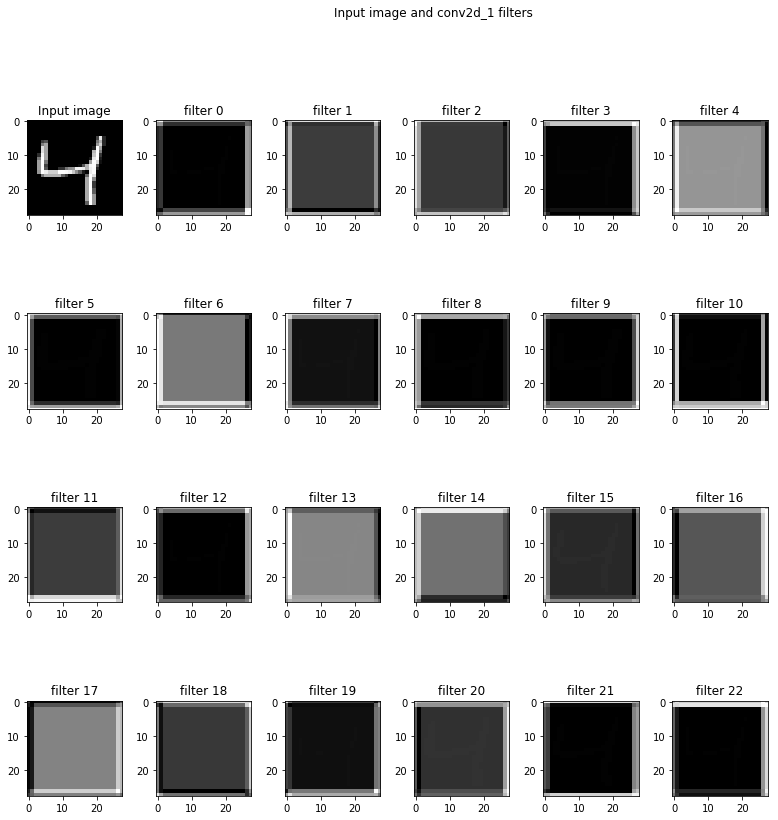

In [0]:
 # use matplotlib to visualize the filter arrays 
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
%matplotlib inline
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(X_train[2]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_1'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    elif layer_output.shape[3] >= 8:
        plot_x, plot_y = 2, 4   
    else:
        
        plot_x, plot_y = 2, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    
    ax[0,0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0,0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x,y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x,y].set_title('filter %d' % (x * plot_y + y - 1))

vis_img_in_filter()

### We built the first iteration of the model with 195k parameters and achieved a max validation accuracy of 99.22 within 10 epochs . This iteration was to fix the basic architecture of the network 

###We will improve this model in the next iteration 